This notebook is for experimenting with different functionality in the MovingPandas library and some seal data from Movebank (see readme for details)

In [16]:
# Imports
import geopandas as gpd
import movingpandas as mpd
import pandas as pd
from datetime import datetime, timedelta

# For custom map tile experimentation - not essential
from geoviews.element import WMTS
import holoviews as hv
from apiKey import apiKey, mapbox_token
# import os
# import imageio
# hv.extension('plotly')
# from holoviews import opts

(Failed) Attempt to make background of hvplot an Ordnance Survey (OS) map tile:

This first cell is my experimentation with trying to use the OS APIs to get OS map vector/raster tiles in the background of my plots, it's not part of the data processing and you can use the tiles argument in the MovingPandas .hvplot() method to change the background to a selection of pre-existing styles. So feel free to skip over the two cells below!

In [ ]:
os_tile = hv.Tiles('https://api.os.uk/maps/raster/v1/zxy/Light_27700/{z}/{x}/{y}.png?key='+apiKey, name="OSmap")

# style?:  https://labs.os.uk/prototyping/os-data-hub/maps/vector/styles/outdoor.json

tiles = hv.Tiles('https://api.os.uk/maps/vector/v1/vts?key='+apiKey).opts(
    mapboxstyle='https://api.os.uk/maps/vector/v1/vts/resources/styles?key='+apiKey,
    accesstoken=mapbox_token,
    width=500,
    height=500,
    padding=0
)
osmaps = hv.Tiles('https://api.os.uk/maps/raster/v1/zxy/Road_3857/{z}/{x}/{y}.png?'+apiKey).opts(width=550, height=550)

In [88]:
tiles

:Tiles   [x,y]

This is where the analysis of moving data begins using the [MovingPandas](https://movingpandas.readthedocs.io/en/main/) library. There are lots of different things you can do with this library so I'd recommend experimenting like I've been doing in this notebook and checking out the docs^. 

Plot seal trajectory:

In [4]:
# Here we use GeoPandas to read in the moving data - in this case a csv with data on the whereabouts of the grey seal.
df = gpd.read_file('data/GreySeal_McConnell_UK.csv')

# The data doesn't have a geometry column, so I create one using the longitude and latitude columns:
df['geometry'] = gpd.GeoSeries.from_xy(df['location-long'], df['location-lat'], crs='epsg:4326')

# This prints out the top three lines of the geodataframe
df.head(3)

event-id visible                timestamp location-long location-lat  \
0  8411662037    true  2008-04-09 15:08:00.000      -2.78853     56.44706   
1  8411662038    true  2008-04-09 15:38:04.000      -2.78434     56.43897   
2  8411662039    true  2008-04-09 16:07:08.000      -2.76453       56.439   

  sensor-type individual-taxon-canonical-name tag-local-identifier  \
0         gps              Halichoerus grypus          gp13-902-08   
1         gps              Halichoerus grypus          gp13-902-08   
2         gps              Halichoerus grypus          gp13-902-08   

  individual-local-identifier             study-name  \
0                 gp13-902-08  GreySeal_McConnell_UK   
1                 gp13-902-08  GreySeal_McConnell_UK   
2                 gp13-902-08  GreySeal_McConnell_UK   

                    geometry  
0  POINT (-2.78853 56.44706)  
1  POINT (-2.78434 56.43897)  
2  POINT (-2.76453 56.43900)

<AxesSubplot:>

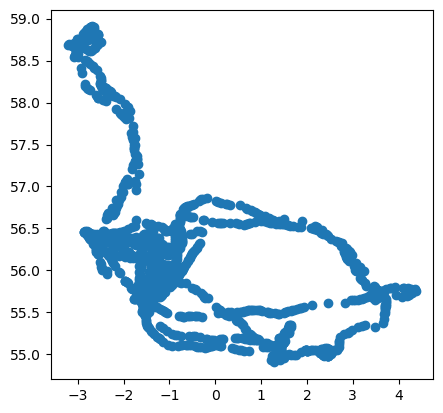

In [5]:
# This plots the data! But without a background map... for that we convert the data to a MovingPandas trajectory and use the hvplot method to visualise the seal tracks
df.plot() 

In [6]:
# Here I was just checking the unique values in the 'individual-taxon-canonical-name' column, and picking out the first one. Obviously there is only one in this case because it's just one seal!

# Create a variable called seal which holds this information to be used later in plot titles
seal = df['individual-taxon-canonical-name'].unique()
seal = df['individual-taxon-canonical-name'].unique()[0]
print(seal)

Halichoerus grypus


In [8]:
# .Trajectory(df, traj_id, obj_id=None, t=None, x=None, y=None, crs='epsg:4326', parent=None)

# Creates a MovingPandas trajectory
traj = mpd.Trajectory(df, 1, t='timestamp')
traj.df.head(2)

event-id visible location-long location-lat  \
timestamp                                                            
2008-04-09 15:08:00  8411662037    true      -2.78853     56.44706   
2008-04-09 15:38:04  8411662038    true      -2.78434     56.43897   

                    sensor-type individual-taxon-canonical-name  \
timestamp                                                         
2008-04-09 15:08:00         gps              Halichoerus grypus   
2008-04-09 15:38:04         gps              Halichoerus grypus   

                    tag-local-identifier individual-local-identifier  \
timestamp                                                              
2008-04-09 15:08:00          gp13-902-08                 gp13-902-08   
2008-04-09 15:38:04          gp13-902-08                 gp13-902-08   

                                study-name                   geometry  
timestamp                                                              
2008-04-09 15:08:00  GreySeal_McConnell_UK  POINT (-2.78853 56.44706)  
2008-04-09 15:38:04  GreySeal_McConnell_UK  POINT (-2.78434 56.43897)

In [9]:
# Checks the crs of the trajectory
traj.df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
# Plots seal movement
traj.hvplot(title=f'Movement of {seal}', line_width=2, frame_width=700, frame_height=500) 

c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]

Find out where seal was on a particular date:

In [11]:
# This checks what the maximum and minimum dates in the data are
df['timestamp'] = pd.to_datetime(df['timestamp'])
date_range = str(df['timestamp'].dt.date.min()) + ' to ' +str(df['timestamp'].dt.date.max())
print(date_range)

2008-04-09 to 2008-12-05


In [12]:
# This allows you to plot the loccation of the tracked object a particular user-specified date (look at the cell below to see it in action)
def plot_location_at_timestamp(traj, timestamp, fig_size=250):
    loc = gpd.GeoDataFrame([traj.get_row_at(timestamp)])
    return (loc.hvplot(title=str(timestamp), geo=True, tiles='OSM', size=200, color='red', width=fig_size, height=fig_size) *
            traj.hvplot(line_width=1.0, color='black', tiles=False, width=fig_size, height=fig_size))

In [11]:
# Plots three plots of the seal location on specified dates
( plot_location_at_timestamp(traj, datetime(2008,12,5)) + 
  plot_location_at_timestamp(traj, datetime(2008,7,20)) +
  plot_location_at_timestamp(traj, datetime(2008,5,1)) )

c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


:Layout
   .Overlay.I   :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Points.I :Points   [Longitude,Latitude]
      .Path.I   :Path   [Longitude,Latitude]
   .Overlay.II  :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Points.I :Points   [Longitude,Latitude]
      .Path.I   :Path   [Longitude,Latitude]
   .Overlay.III :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Points.I :Points   [Longitude,Latitude]
      .Path.I   :Path   [Longitude,Latitude]

The following cells estimate and plot the seal speed:

In [13]:
# This is a straightforward method you can call to add a speed column to your data
traj.add_speed(overwrite=True)
traj.df.head(4)

event-id visible location-long location-lat  \
timestamp                                                            
2008-04-09 15:08:00  8411662037    true      -2.78853     56.44706   
2008-04-09 15:38:04  8411662038    true      -2.78434     56.43897   
2008-04-09 16:07:08  8411662039    true      -2.76453       56.439   
2008-04-09 16:37:12  8411662040    true      -2.74011     56.43968   

                    sensor-type individual-taxon-canonical-name  \
timestamp                                                         
2008-04-09 15:08:00         gps              Halichoerus grypus   
2008-04-09 15:38:04         gps              Halichoerus grypus   
2008-04-09 16:07:08         gps              Halichoerus grypus   
2008-04-09 16:37:12         gps              Halichoerus grypus   

                    tag-local-identifier individual-local-identifier  \
timestamp                                                              
2008-04-09 15:08:00          gp13-902-08                 gp13-902-08   
2008-04-09 15:38:04          gp13-902-08                 gp13-902-08   
2008-04-09 16:07:08          gp13-902-08                 gp13-902-08   
2008-04-09 16:37:12          gp13-902-08                 gp13-902-08   

                                study-name                   geometry  \
timestamp                                                               
2008-04-09 15:08:00  GreySeal_McConnell_UK  POINT (-2.78853 56.44706)   
2008-04-09 15:38:04  GreySeal_McConnell_UK  POINT (-2.78434 56.43897)   
2008-04-09 16:07:08  GreySeal_McConnell_UK  POINT (-2.76453 56.43900)   
2008-04-09 16:37:12  GreySeal_McConnell_UK  POINT (-2.74011 56.43968)   

                        speed  
timestamp                      
2008-04-09 15:08:00  0.519488  
2008-04-09 15:38:04  0.519488  
2008-04-09 16:07:08  0.700664  
2008-04-09 16:37:12  0.836033

c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

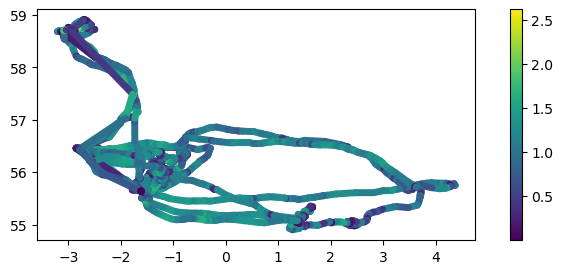

In [14]:
# This plots that speed
traj.plot(column='speed', linewidth=5, capstyle='round', figsize=(9,3), legend=True)

In [15]:
# This plots the speed but with a background map
traj.hvplot(c='speed', line_width=2.5, cmap='Viridis', colorbar=True, tiles='CartoDark', width=700, height=500)

c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]   (speed)

In [18]:
# gdf = gpd.GeoDataFrame(df, crs='epsg:4326')

In [19]:
# gdf['geometry'].explore(tiles='https://api.os.uk/maps/raster/v1/zxy/Light_3857/{z}/{x}/{y}.png?key='+apiKey, attr='OS Maps')

Here we look at detecting stops:

In [20]:
detector = mpd.TrajectoryStopDetector(traj)
stops = detector.get_stop_points(min_duration=timedelta(hours=1),
                                     max_diameter=100)
stops

c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\movingpandas\geometry_utils.py:150: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(geom) == 2:
c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\movingpandas\geometry_utils.py:151: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return _measure_distance(geom[0], geom[1], spherical)


geometry          start_time  \
stop_id                                                                
1_2008-04-29 05:37:00  POINT (-1.61044 55.64574) 2008-04-29 05:37:00   
1_2008-04-30 22:41:24  POINT (-1.61077 55.64546) 2008-04-30 22:41:24   
1_2008-05-07 14:07:00  POINT (-2.79983 56.43634) 2008-05-07 14:07:00   
1_2008-05-08 19:07:00  POINT (-2.79987 56.43629) 2008-05-08 19:07:00   
1_2008-05-09 20:07:00  POINT (-2.79929 56.43620) 2008-05-09 20:07:00   
...                                          ...                 ...   
1_2008-10-24 06:37:00  POINT (-1.62280 55.63973) 2008-10-24 06:37:00   
1_2008-11-08 13:37:00  POINT (-2.93154 58.68701) 2008-11-08 13:37:00   
1_2008-11-12 02:37:12  POINT (-2.70489 58.90445) 2008-11-12 02:37:12   
1_2008-11-19 08:37:00  POINT (-2.79886 56.43461) 2008-11-19 08:37:00   
1_2008-12-03 09:37:00  POINT (-1.62270 55.63922) 2008-12-03 09:37:00   

                                 end_time  traj_id  duration_s  
stop_id                                                         
1_2008-04-29 05:37:00 2008-04-29 08:16:44        1      9584.0  
1_2008-04-30 22:41:24 2008-05-01 01:37:00        1     10536.0  
1_2008-05-07 14:07:00 2008-05-08 17:39:48        1     99168.0  
1_2008-05-08 19:07:00 2008-05-09 08:07:00        1     46800.0  
1_2008-05-09 20:07:00 2008-05-10 05:22:20        1     33320.0  
...                                   ...      ...         ...  
1_2008-10-24 06:37:00 2008-10-24 08:07:00        1      5400.0  
1_2008-11-08 13:37:00 2008-11-08 17:07:00        1     12600.0  
1_2008-11-12 02:37:12 2008-11-12 04:37:04        1      7192.0  
1_2008-11-19 08:37:00 2008-11-19 21:37:00        1     46800.0  
1_2008-12-03 09:37:00 2008-12-05 18:07:00        1    203400.0  

[64 rows x 5 columns]

In [21]:
# This creates extra columns for the stop duration in minutes and hours.
stops['duration_m'] = stops['duration_s']/60
stops['duration_h'] = stops['duration_m']/60
stops.head()

geometry          start_time  \
stop_id                                                                
1_2008-04-29 05:37:00  POINT (-1.61044 55.64574) 2008-04-29 05:37:00   
1_2008-04-30 22:41:24  POINT (-1.61077 55.64546) 2008-04-30 22:41:24   
1_2008-05-07 14:07:00  POINT (-2.79983 56.43634) 2008-05-07 14:07:00   
1_2008-05-08 19:07:00  POINT (-2.79987 56.43629) 2008-05-08 19:07:00   
1_2008-05-09 20:07:00  POINT (-2.79929 56.43620) 2008-05-09 20:07:00   

                                 end_time  traj_id  duration_s   duration_m  \
stop_id                                                                       
1_2008-04-29 05:37:00 2008-04-29 08:16:44        1      9584.0   159.733333   
1_2008-04-30 22:41:24 2008-05-01 01:37:00        1     10536.0   175.600000   
1_2008-05-07 14:07:00 2008-05-08 17:39:48        1     99168.0  1652.800000   
1_2008-05-08 19:07:00 2008-05-09 08:07:00        1     46800.0   780.000000   
1_2008-05-09 20:07:00 2008-05-10 05:22:20        1     33320.0   555.333333   

                       duration_h  
stop_id                            
1_2008-04-29 05:37:00    2.662222  
1_2008-04-30 22:41:24    2.926667  
1_2008-05-07 14:07:00   27.546667  
1_2008-05-08 19:07:00   13.000000  
1_2008-05-09 20:07:00    9.255556

In [22]:
# This plots stop duration - the colours represent how long the seal is stopped for
stop_point_plot = stops.hvplot(c='duration_h', geo=True, cmap='Viridis', colorbar=True, tiles='CartoDark', width=700, height=500)

In [23]:
traj_plot = traj.hvplot(line_width=2.5, tiles='CartoLight', color='darkgray') * stops.hvplot(c='duration_h', geo=True, cmap='Viridis', colorbar=True)
traj_plot

c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (duration_h)

In [24]:
traj_plot = traj.hvplot(c='speed', line_width=2.5, cmap='Viridis', colorbar=True, tiles='CartoDark', width=700, height=500) * stops.hvplot(c='duration_h', geo=True, color='white')
traj_plot

c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]   (speed)
   .Points.I :Points   [Longitude,Latitude]

Splitting at stops

The following cells split the trajectory into several smaller trajectories so that we can see the separate journeys of the seal where the journey begins and ends with the seal stopping somewhere.

In [25]:
split = mpd.StopSplitter(traj).split(min_duration=timedelta(minutes=30), max_diameter=100)

c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\movingpandas\geometry_utils.py:150: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(geom) == 2:
c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\movingpandas\geometry_utils.py:151: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return _measure_distance(geom[0], geom[1], spherical)


In [26]:
split

TrajectoryCollection with 107 trajectories

In [27]:
split.to_traj_gdf()

traj_id             start_t               end_t  \
0    1_2008-04-09 15:08:00 2008-04-09 15:08:00 2008-04-29 05:37:00   
1    1_2008-04-29 08:16:44 2008-04-29 08:16:44 2008-04-30 22:41:24   
2    1_2008-05-01 01:37:00 2008-05-01 01:37:00 2008-05-02 04:07:00   
3    1_2008-05-02 04:37:00 2008-05-02 04:37:00 2008-05-06 02:11:32   
4    1_2008-05-06 03:07:00 2008-05-06 03:07:00 2008-05-06 04:07:32   
..                     ...                 ...                 ...   
102  1_2008-10-24 08:07:00 2008-10-24 08:07:00 2008-11-08 13:37:00   
103  1_2008-11-08 17:07:00 2008-11-08 17:07:00 2008-11-12 03:39:44   
104  1_2008-11-12 04:37:04 2008-11-12 04:37:04 2008-11-13 04:39:56   
105  1_2008-11-13 05:37:00 2008-11-13 05:37:00 2008-11-19 08:37:00   
106  1_2008-11-19 21:37:00 2008-11-19 21:37:00 2008-12-03 09:37:00   

                                              geometry        length  \
0    LINESTRING (-2.78853 56.44706, -2.78434 56.438...  1.317282e+06   
1    LINESTRING (-1.60932 55.64520, -1.60551 55.642...  6.678290e+03   
2    LINESTRING (-1.61069 55.64563, -1.60594 55.643...  1.619414e+04   
3    LINESTRING (-1.60558 55.64230, -1.59298 55.645...  2.361451e+05   
4    LINESTRING (-1.26276 56.33158, -1.26354 56.330...  2.282617e+02   
..                                                 ...           ...   
102  LINESTRING (-1.62223 55.63948, -1.60363 55.642...  4.360882e+05   
103  LINESTRING (-2.93126 58.68753, -2.93311 58.687...  3.948532e+04   
104  LINESTRING (-2.70451 58.90421, -2.70532 58.898...  7.936074e+03   
105  LINESTRING (-2.70254 58.89893, -2.92623 58.723...  3.148850e+05   
106  LINESTRING (-2.79891 56.43466, -2.79720 56.434...  1.208570e+05   

      direction  
0    140.119690  
1    287.628213  
2    131.538677  
3     15.463301  
4    119.766366  
..          ...  
102  347.434169  
103   28.246322  
104  167.059594  
105  181.238375  
106  139.951463  

[107 rows x 6 columns]

In [28]:
# Here we get stop points where the seal stopped for 30 minutes or more
stops_30min = detector.get_stop_points(min_duration=timedelta(minutes=30),
                                     max_diameter=100)

c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\movingpandas\geometry_utils.py:150: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(geom) == 2:
c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\movingpandas\geometry_utils.py:151: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return _measure_distance(geom[0], geom[1], spherical)


In [29]:
stops_30min['duration_m'] = stops_30min['duration_s']/60

In [30]:
split.hvplot(title='Trajectory split at stops where the min duration was 30 mins', line_width=3.0, tiles='CartoDark') * stops_30min.hvplot(c='duration_m', geo=True, color='white')

c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWar

:Overlay
   .Tiles.I       :Tiles   [x,y]
   .Path.I        :Path   [Longitude,Latitude]
   .Path.II       :Path   [Longitude,Latitude]
   .Path.III      :Path   [Longitude,Latitude]
   .Path.IV       :Path   [Longitude,Latitude]
   .Path.V        :Path   [Longitude,Latitude]
   .Path.VI       :Path   [Longitude,Latitude]
   .Path.VII      :Path   [Longitude,Latitude]
   .Path.VIII     :Path   [Longitude,Latitude]
   .Path.IX       :Path   [Longitude,Latitude]
   .Path.X        :Path   [Longitude,Latitude]
   .Path.XI       :Path   [Longitude,Latitude]
   .Path.XII      :Path   [Longitude,Latitude]
   .Path.XIII     :Path   [Longitude,Latitude]
   .Path.XIV      :Path   [Longitude,Latitude]
   .Path.XV       :Path   [Longitude,Latitude]
   .Path.XVI      :Path   [Longitude,Latitude]
   .Path.XVII     :Path   [Longitude,Latitude]
   .Path.XVIII    :Path   [Longitude,Latitude]
   .Path.XIX      :Path   [Longitude,Latitude]
   .Path.XX       :Path   [Longitude,Latitude]
   .Path.XXI      :Path   [Longitude,Latitude]
   .Path.XXII     :Path   [Longitude,Latitude]
   .Path.XXIII    :Path   [Longitude,Latitude]
   .Path.XXIV     :Path   [Longitude,Latitude]
   .Path.XXV      :Path   [Longitude,Latitude]
   .Path.XXVI     :Path   [Longitude,Latitude]
   .Path.XXVII    :Path   [Longitude,Latitude]
   .Path.XXVIII   :Path   [Longitude,Latitude]
   .Path.XXIX     :Path   [Longitude,Latitude]
   .Path.XXX      :Path   [Longitude,Latitude]
   .Path.XXXI     :Path   [Longitude,Latitude]
   .Path.XXXII    :Path   [Longitude,Latitude]
   .Path.XXXIII   :Path   [Longitude,Latitude]
   .Path.XXXIV    :Path   [Longitude,Latitude]
   .Path.XXXV     :Path   [Longitude,Latitude]
   .Path.XXXVI    :Path   [Longitude,Latitude]
   .Path.XXXVII   :Path   [Longitude,Latitude]
   .Path.XXXVIII  :Path   [Longitude,Latitude]
   .Path.XXXIX    :Path   [Longitude,Latitude]
   .Path.XL       :Path   [Longitude,Latitude]
   .Path.XLI      :Path   [Longitude,Latitude]
   .Path.XLII     :Path   [Longitude,Latitude]
   .Path.XLIII    :Path   [Longitude,Latitude]
   .Path.XLIV     :Path   [Longitude,Latitude]
   .Path.XLV      :Path   [Longitude,Latitude]
   .Path.XLVI     :Path   [Longitude,Latitude]
   .Path.XLVII    :Path   [Longitude,Latitude]
   .Path.XLVIII   :Path   [Longitude,Latitude]
   .Path.XLIX     :Path   [Longitude,Latitude]
   .Path.L        :Path   [Longitude,Latitude]
   .Path.LI       :Path   [Longitude,Latitude]
   .Path.LII      :Path   [Longitude,Latitude]
   .Path.LIII     :Path   [Longitude,Latitude]
   .Path.LIV      :Path   [Longitude,Latitude]
   .Path.LV       :Path   [Longitude,Latitude]
   .Path.LVI      :Path   [Longitude,Latitude]
   .Path.LVII     :Path   [Longitude,Latitude]
   .Path.LVIII    :Path   [Longitude,Latitude]
   .Path.LIX      :Path   [Longitude,Latitude]
   .Path.LX       :Path   [Longitude,Latitude]
   .Path.LXI      :Path   [Longitude,Latitude]
   .Path.LXII     :Path   [Longitude,Latitude]
   .Path.LXIII    :Path   [Longitude,Latitude]
   .Path.LXIV     :Path   [Longitude,Latitude]
   .Path.LXV      :Path   [Longitude,Latitude]
   .Path.LXVI     :Path   [Longitude,Latitude]
   .Path.LXVII    :Path   [Longitude,Latitude]
   .Path.LXVIII   :Path   [Longitude,Latitude]
   .Path.LXIX     :Path   [Longitude,Latitude]
   .Path.LXX      :Path   [Longitude,Latitude]
   .Path.LXXI     :Path   [Longitude,Latitude]
   .Path.LXXII    :Path   [Longitude,Latitude]
   .Path.LXXIII   :Path   [Longitude,Latitude]
   .Path.LXXIV    :Path   [Longitude,Latitude]
   .Path.LXXV     :Path   [Longitude,Latitude]
   .Path.LXXVI    :Path   [Longitude,Latitude]
   .Path.LXXVII   :Path   [Longitude,Latitude]
   .Path.LXXVIII  :Path   [Longitude,Latitude]
   .Path.LXXIX    :Path   [Longitude,Latitude]
   .Path.LXXX     :Path   [Longitude,Latitude]
   .Path.LXXXI    :Path   [Longitude,Latitude]
   .Path.LXXXII   :Path   [Longitude,Latitude]
   .Path.LXXXIII  :Path   [Longitude,Latitude]
   .Path.LXXXIV   :Path   [Longitude,Latitude]
   .Path.L

Here we look at stop segments:

In [31]:
stop_segs = detector.get_stop_segments(min_duration=timedelta(seconds=60), max_diameter=100)

c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\movingpandas\geometry_utils.py:150: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(geom) == 2:
c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\movingpandas\geometry_utils.py:151: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return _measure_distance(geom[0], geom[1], spherical)


In [32]:
stop_segment_plot = stop_segs.hvplot( size=200, line_width=7.0, color='orange', tiles='CartoDark')
stop_segment_plot

c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\MMarochov\Anaconda3\envs\mpd-ex\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWar

:Overlay
   .Tiles.I       :Tiles   [x,y]
   .Path.I        :Path   [Longitude,Latitude]
   .Path.II       :Path   [Longitude,Latitude]
   .Path.III      :Path   [Longitude,Latitude]
   .Path.IV       :Path   [Longitude,Latitude]
   .Path.V        :Path   [Longitude,Latitude]
   .Path.VI       :Path   [Longitude,Latitude]
   .Path.VII      :Path   [Longitude,Latitude]
   .Path.VIII     :Path   [Longitude,Latitude]
   .Path.IX       :Path   [Longitude,Latitude]
   .Path.X        :Path   [Longitude,Latitude]
   .Path.XI       :Path   [Longitude,Latitude]
   .Path.XII      :Path   [Longitude,Latitude]
   .Path.XIII     :Path   [Longitude,Latitude]
   .Path.XIV      :Path   [Longitude,Latitude]
   .Path.XV       :Path   [Longitude,Latitude]
   .Path.XVI      :Path   [Longitude,Latitude]
   .Path.XVII     :Path   [Longitude,Latitude]
   .Path.XVIII    :Path   [Longitude,Latitude]
   .Path.XIX      :Path   [Longitude,Latitude]
   .Path.XX       :Path   [Longitude,Latitude]
   .Path.XXI      :Path   [Longitude,Latitude]
   .Path.XXII     :Path   [Longitude,Latitude]
   .Path.XXIII    :Path   [Longitude,Latitude]
   .Path.XXIV     :Path   [Longitude,Latitude]
   .Path.XXV      :Path   [Longitude,Latitude]
   .Path.XXVI     :Path   [Longitude,Latitude]
   .Path.XXVII    :Path   [Longitude,Latitude]
   .Path.XXVIII   :Path   [Longitude,Latitude]
   .Path.XXIX     :Path   [Longitude,Latitude]
   .Path.XXX      :Path   [Longitude,Latitude]
   .Path.XXXI     :Path   [Longitude,Latitude]
   .Path.XXXII    :Path   [Longitude,Latitude]
   .Path.XXXIII   :Path   [Longitude,Latitude]
   .Path.XXXIV    :Path   [Longitude,Latitude]
   .Path.XXXV     :Path   [Longitude,Latitude]
   .Path.XXXVI    :Path   [Longitude,Latitude]
   .Path.XXXVII   :Path   [Longitude,Latitude]
   .Path.XXXVIII  :Path   [Longitude,Latitude]
   .Path.XXXIX    :Path   [Longitude,Latitude]
   .Path.XL       :Path   [Longitude,Latitude]
   .Path.XLI      :Path   [Longitude,Latitude]
   .Path.XLII     :Path   [Longitude,Latitude]
   .Path.XLIII    :Path   [Longitude,Latitude]
   .Path.XLIV     :Path   [Longitude,Latitude]
   .Path.XLV      :Path   [Longitude,Latitude]
   .Path.XLVI     :Path   [Longitude,Latitude]
   .Path.XLVII    :Path   [Longitude,Latitude]
   .Path.XLVIII   :Path   [Longitude,Latitude]
   .Path.XLIX     :Path   [Longitude,Latitude]
   .Path.L        :Path   [Longitude,Latitude]
   .Path.LI       :Path   [Longitude,Latitude]
   .Path.LII      :Path   [Longitude,Latitude]
   .Path.LIII     :Path   [Longitude,Latitude]
   .Path.LIV      :Path   [Longitude,Latitude]
   .Path.LV       :Path   [Longitude,Latitude]
   .Path.LVI      :Path   [Longitude,Latitude]
   .Path.LVII     :Path   [Longitude,Latitude]
   .Path.LVIII    :Path   [Longitude,Latitude]
   .Path.LIX      :Path   [Longitude,Latitude]
   .Path.LX       :Path   [Longitude,Latitude]
   .Path.LXI      :Path   [Longitude,Latitude]
   .Path.LXII     :Path   [Longitude,Latitude]
   .Path.LXIII    :Path   [Longitude,Latitude]
   .Path.LXIV     :Path   [Longitude,Latitude]
   .Path.LXV      :Path   [Longitude,Latitude]
   .Path.LXVI     :Path   [Longitude,Latitude]
   .Path.LXVII    :Path   [Longitude,Latitude]
   .Path.LXVIII   :Path   [Longitude,Latitude]
   .Path.LXIX     :Path   [Longitude,Latitude]
   .Path.LXX      :Path   [Longitude,Latitude]
   .Path.LXXI     :Path   [Longitude,Latitude]
   .Path.LXXII    :Path   [Longitude,Latitude]
   .Path.LXXIII   :Path   [Longitude,Latitude]
   .Path.LXXIV    :Path   [Longitude,Latitude]
   .Path.LXXV     :Path   [Longitude,Latitude]
   .Path.LXXVI    :Path   [Longitude,Latitude]
   .Path.LXXVII   :Path   [Longitude,Latitude]
   .Path.LXXVIII  :Path   [Longitude,Latitude]
   .Path.LXXIX    :Path   [Longitude,Latitude]
   .Path.LXXX     :Path   [Longitude,Latitude]
   .Path.LXXXI    :Path   [Longitude,Latitude]
   .Path.LXXXII   :Path   [Longitude,Latitude]
   .Path.LXXXIII  :Path   [Longitude,Latitude]
   .Path.LXXXIV   :Path   [Longitude,Latitude]
   .Path.L